# Three-bus power flow example

Example 5.4 given at page 89 of Ned Mohan's Book. Based on network shown at page 80 and gradually described in the other examples.

Buses:

 - Bus 1 is the slack, with voltage at 1 pu
 - Bus 2 is a PV bus, with voltage at 1.05 pu and drawing 2 pu of active power
 - Bus 3 is a PQ bus, consumed P = 5 pu and Q = 1 pu.

Lines:

 - Shunt susceptances are ignored (4.5e-6 S/km)
 - X = 0.376 Ohm/km (at 6h Hz)
 - R = 0.037 Ohm/km
 - 1 to 2: 150 km
 - 2 to 3: 150 km
 - 3 to 1: 200 km


Voltage base (3-phase): 345 kV

Power base (3-phase): 100 MVA

TODO:

 - base values
 - line params

In [ ]:
#pip install pandapower

In [1]:
import pandapower as pp
import plotly
#create empty net
net = pp.create_empty_network()

# Per unit (3-phase values)
Pbase = 100  # MVA
Vbase = 345 # kV

#create buses
b1 = pp.create_bus(net, vn_kv=Vbase, name="Bus 1", geodata=(0,1))
b2 = pp.create_bus(net, vn_kv=Vbase, name="Bus 2", geodata=(2.5,0))
b3 = pp.create_bus(net, vn_kv=Vbase, name="Bus 3", geodata=(5,1))

#create bus elements
pp.create_ext_grid(net, bus=b1, vm_pu=1.00, name="Grid Connection") #utility
pp.create_load(net, bus=b3, p_mw=5*Pbase, q_mvar=1*Pbase, name="Load") #load
pp.create_gen(net, bus=b2, p_mw=2*Pbase, vm_pu=1.05, name="PV") #generator

#create branch elements. Here I use impedances since we do not have accurate info about line types.
Zbase = Vbase**2 / Pbase
X_km = 0.376
R_km = 0.037
l12_km = 150
l23_km = 150
l31_km = 200


pp.create_line_from_parameters(net, name="line1", from_bus = b1, to_bus = b2,
                               length_km=l12_km, r_ohm_per_km = R_km, x_ohm_per_km = X_km,
                               c_nf_per_km = 0, max_i_ka = 0.2)
pp.create_line_from_parameters(net, name="line2", from_bus = b2, to_bus = b3,
                               length_km=l23_km, r_ohm_per_km = R_km, x_ohm_per_km = X_km,
                               c_nf_per_km = 0, max_i_ka = 0.2)
pp.create_line_from_parameters(net, name="line3", from_bus = b3, to_bus = b1,
                               length_km=l31_km, r_ohm_per_km = R_km, x_ohm_per_km = X_km,
                               c_nf_per_km = 0, max_i_ka = 0.2)



np.int64(2)

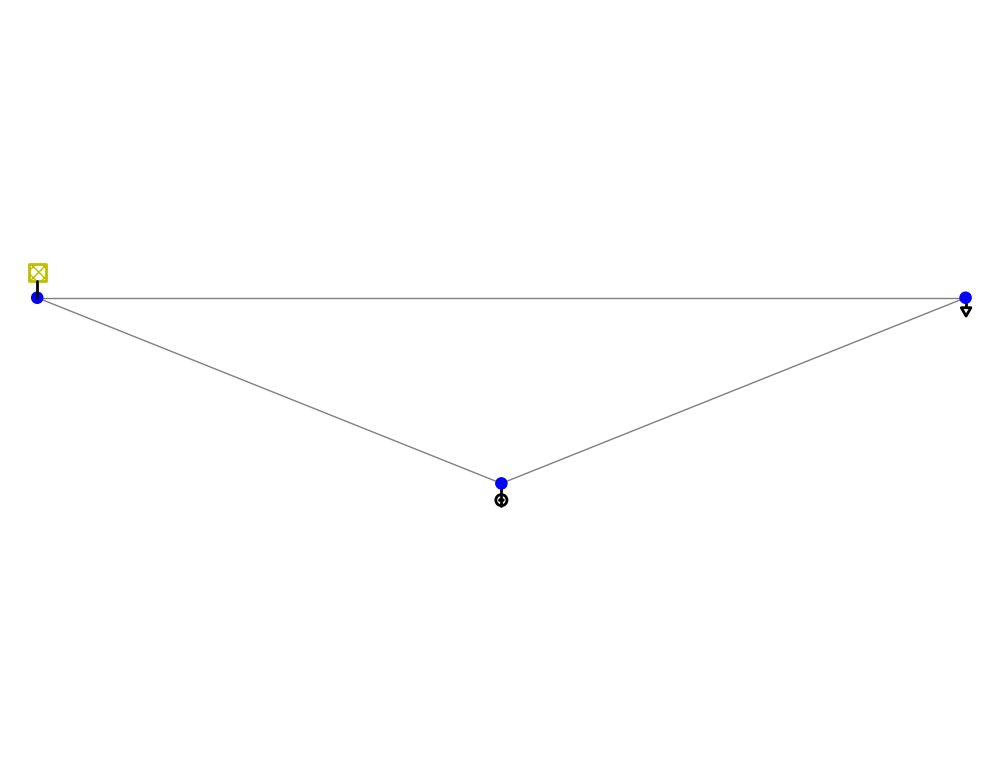

<Axes: >

In [7]:
from pandapower.plotting import simple_plot
simple_plot(net,plot_sgens=True,plot_gens=True, plot_loads=True,plot_line_switches=True)


## Run the power flow and analyze the results

In [ ]:
pp.runpp(net)

In [ ]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-308.377053,81.610978
1,1.050000,-2.066481,-200.000000,-266.739953
2,0.978114,-8.787327,500.000000,100.000000


In [ ]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,68.993240,-110.866762,-68.198148,118.946619,0.795092,8.079857,0.218525,0.218525,0.218525,1.000000,0.000000,1.050000,-2.066481,109.262631
1,268.198148,147.793334,-264.232131,-107.490029,3.966017,40.303305,0.488057,0.488057,0.488057,1.050000,-2.066481,0.978114,-8.787327,244.028279
2,-235.767869,7.490029,239.383813,29.255784,3.615944,36.745813,0.403584,0.403584,0.403584,0.978114,-8.787327,1.000000,0.000000,201.792206


In [ ]:
from pandapower.plotting.plotly import pf_res_plotly
pf_res_plotly(net)

BCR's comment, results are coherent with solution from the book (at first attempt!)

# Scenario 1

The above system is modified to resemble the case of a doubly-fed substation.

In [ ]:
import pandapower as pp
import numpy as np

#create empty net
net = pp.create_empty_network()

# Per unit (3-phase values)
Pbase = 10  # MVA, base MVA is 10 as guided by IEEE 3002.2 – Load Flow Analysis of Industrial and Commercial Power Systems.
Vbase = 12 # kV

#create buses
b0 = pp.create_bus(net, vn_kv=Vbase, name="Bus 0", geodata=(0,5))
b1 = pp.create_bus(net, vn_kv=Vbase, name="Bus 1", geodata=(0,3))
b2 = pp.create_bus(net, vn_kv=Vbase, name="Bus 2", geodata=(5,3))
b3 = pp.create_bus(net, vn_kv=Vbase, name="Bus 3", geodata=(5,5))

#create bus elements
pp.create_ext_grid(net, bus=b0, vm_pu=1.00, name="SS1_Incomer") #utility
pp.create_gen(net, bus=b3, p_mw=0.5*Pbase, vm_pu=1.00, name="SS2_Incomer") #generator

# --- LOAD 001 ---
S1 = 5  # MVA
pf1 = 0.95  # lagging
P1 = S1 * pf1  # MW
Q1 = np.sqrt(S1**2 - P1**2)  # MVAr

pp.create_load(net, bus=b1, p_mw=P1, q_mvar=Q1, name="LOAD_001")

# --- LOAD 002 ---
S2 = 5  # MVA
pf2 = 0.95  # lagging
P2 = S2 * pf2  # MW
Q2 = np.sqrt(S2**2 - P2**2)  # MVAr

pp.create_load(net, bus=b2, p_mw=P2, q_mvar=Q2, name="LOAD_002")

line_type = "N2XS(FL)2Y 1x300 RM/35 64/110 kV"

pp.create_line(net, from_bus=b0, to_bus=b1, length_km=0.1, std_type=line_type, name="TL1", in_service=True)
pp.create_line(net, from_bus=b3, to_bus=b2, length_km=0.1, std_type=line_type, name="TL2", in_service=True)
pp.create_line(net, from_bus=b1, to_bus=b2, length_km=0.1, std_type=line_type, name="TL3(TIE-LINE)", in_service=True)

np.int64(2)

In [ ]:
pp.runpp(net)

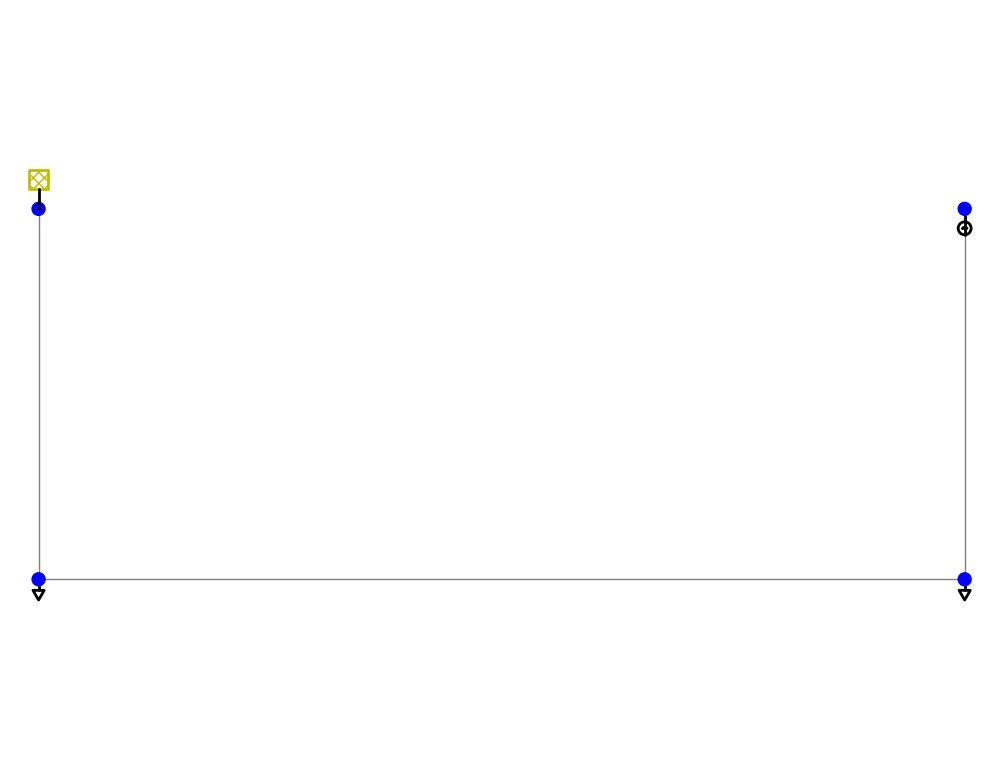

<Axes: >

In [9]:
from pandapower.plotting import simple_plot
simple_plot(net,plot_sgens=True,plot_gens=True, plot_loads=True,plot_line_switches=True)

In [2]:
import pandas as pd

# Run power flow first
pp.runpp(net)

# Merge the line results with the line names
line_results = net.res_line.copy()
line_results['name'] = net.line['name'].values  # add name column from net.line

# Convert current from kA to A
line_results['i_from_a'] = line_results['i_from_ka'] * 1000
line_results['i_to_a'] = line_results['i_to_ka'] * 1000

# Select and reorder relevant columns
line_current_df = line_results[['name', 'i_from_a', 'i_to_a','i_ka']]

# Display the final result
print(line_current_df)


            name    i_from_a      i_to_a      i_ka
0            TL1  230.968123  230.978997  0.230979
1            TL2  250.597929  250.606704  0.250607
2  TL3(TIE-LINE)   12.971529   12.983588  0.012984


In [3]:
# Step 1: Run base case
pp.runpp(net)
print("Base case: Success =", net["converged"])

# Step 2: Find index of the line named "TL2"
line_idx = net.line[net.line['name'] == 'TL2'].index[0]

# Step 3: Set the line out of service (simulate outage)
net.line.at[line_idx, 'in_service'] = False

# Step 4: Run power flow with TL1 offline
pp.runpp(net)
print("Contingency case (TL2 outage): Success =", net["converged"])

# Step 5: Analyze results (optional)
print(net.res_line[['i_from_ka', 'i_to_ka']])


Base case: Success = True
Contingency case (TL2 outage): Success = True
   i_from_ka   i_to_ka
0   0.481532  0.481542
1        NaN  0.000000
2   0.240809  0.240819
